![](https://drive.google.com/uc?export=view&id=1lvXEUvYLv1_uNRzjYczEZz3Q1INXsNjx)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import yfinance as yf
from scipy.stats import norm        # normal (continous) random variable

import datetime
import requests
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

Ta giả sử lợi nhuận trong ngày tuần theo phân phối chuẩn chuẩn tắc (mean=0 và std=1).

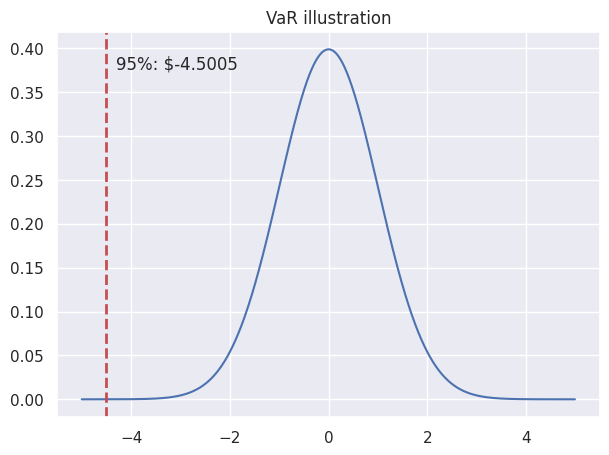

In [ ]:
mean, std = 0, 1

x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std)    # create a pdf with mean=0 and std=1

plt.figure(figsize=(7, 5))
plt.plot(x, y)                # plot the pdf

min_ylim, max_ylim = plt.ylim()
plt.axvline(np.percentile(x, 5), color='r', linestyle='--', lw=2)   # compute the location of 5% percentile of the array x
plt.text(x=np.percentile(x, 5) + 0.2, y=max_ylim * 0.9, s=f'95%: ${np.percentile(x, 5):.4f}')
plt.title('VaR illustration')
plt.show()

Nhận xét:
- Cách tính trên không đúng vì nó chỉ dựa vào percentile (hay quantile) của trục $Ox$ chứ không tính percentile dựa vào phân phối (tích lũy). Dữ liệu ta đưa ra là hàm phân phối chuẩn chứ không phải mảng các giá trị lợi nhuận.
- Cách tính percentile của Toán và Lập trình đúng vì input đầu vào của nó là mảng dữ liệu $x$ chứ không phải là phân phối xác suất, từ đó ta có thể tính được percentile dựa vào mảng được sắp xếp.

Percentile thứ k: giá trị mà tại đó số giá trị thấp hơn nó (tức phân phối tích lũy) có (tỷ lệ) phần trăm là k.

Ví dụ: trong nhóm 20 người, ta là người cao thứ 4 (tức chiều cao chỉ thua 3 người) $\Rightarrow$ 80% (16/20) số người thấp hơn bạn $\Rightarrow$ ta nằm tại percentile thứ 80.

Ta sửa lại ví dụ trên cho đúng: ta sử dụng hàm norm.ppf của scipy, tức percent point function, là tên gọi khác của hàm quantile.

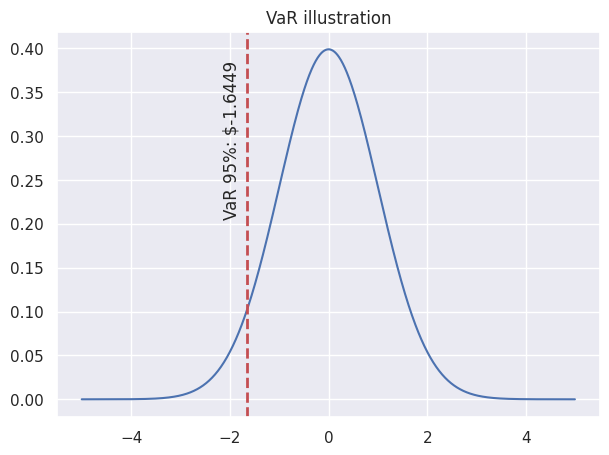

In [ ]:
mean, std = 0, 1

x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std)    # create a pdf with mean=0 and std=1

plt.figure(figsize=(7, 5))
plt.plot(x, y)                # plot the pdf

min_ylim, max_ylim = plt.ylim()
var_95 = norm.ppf(0.05, mean, std)   # point percentile function
plt.axvline(var_95, color='r', linestyle='--', lw=2)   # compute the location of 5% percentile of the array x
plt.text(x=var_95 - 0.5, y=max_ylim * 0.5, s=f'VaR 95%: ${var_95:.4f}', rotation='vertical')
plt.title('VaR illustration')
plt.show()

OK! Ta đã sửa xong rồi!

# Portfolio VaR using variance-covariance method

Các bước tính toán:

In [ ]:
tickers = ['AAPL', 'C', 'DIS', 'META']    # create portfolio of equities
weights = np.array([.25, .3, .15, 3])     # set arbitrarily weights

init_investment = 1_000_000

start = datetime.datetime(2018, 1, 1)
end = datetime.datetime.today()
data = yf.download(tickers, start=start, end=end, interval='1d')['Close']

data.head()

[*********************100%%**********************]  4 of 4 completed


,AAPL,C,DIS,META
Date,,,,
2018-01-02,43.064999,74.360001,111.800003,181.419998
2018-01-03,43.057499,74.589996,112.279999,184.669998
2018-01-04,43.257500,75.510002,112.230003,184.330002
2018-01-05,43.750000,75.410004,111.620003,186.850006
2018-01-08,43.587502,74.529999,110.019997,188.279999


In [ ]:
type(data)

pandas.core.frame.DataFrame

- pct_change() method (pandas): returns a DataFrame with the percentage difference between the values for each row and, by default, the previous row. Which row to compare with can be specified with the periods parameter.

In [ ]:
# Calculate periodic returns
rets = data.pct_change()
rets.head()

,AAPL,C,DIS,META
Date,,,,
2018-01-02,NaN,NaN,NaN,NaN
2018-01-03,-0.000174,0.003093,0.004293,0.017914
2018-01-04,0.004645,0.012334,-0.000445,-0.001841
2018-01-05,0.011385,-0.001324,-0.005435,0.013671
2018-01-08,-0.003714,-0.011670,-0.014334,0.007653


In [ ]:
# Create a variance-covariance matrix based on the returns
cov_mat = rets.cov()           # cov() method for pd.DataFrame
cov_mat

,AAPL,C,DIS,META
AAPL,0.000410,0.000222,0.000193,0.000316
C,0.000222,0.000553,0.000282,0.000228
DIS,0.000193,0.000282,0.000406,0.000224
META,0.000316,0.000228,0.000224,0.000743


In [ ]:
corr_mat = rets.corr()    # correlation matrix
corr_mat

,AAPL,C,DIS,META
AAPL,1.000000,0.464838,0.473572,0.572365
C,0.464838,1.000000,0.596087,0.355098
DIS,0.473572,0.596087,1.000000,0.408234
META,0.572365,0.355098,0.408234,1.000000


In [ ]:
# Calculate portfolio mean and std
avg_rets = rets.mean()      # calculate average returns for each stock (each column)
avg_rets

AAPL    0.001182
C      -0.000144
DIS     0.000006
META    0.000763
dtype: float64

In [ ]:
# Calculate portfolio return's mean
ptf_mean = avg_rets.dot(weights)     # This is basic formula: E[aX + bY + cZ + dT] = a*E[X] + b*E[Y] + c*E[Z] + d*E[T]
ptf_mean

0.002540880399987851

In [ ]:
# Calculate portfolio return's std
ptf_std = np.sqrt(weights.T.dot(cov_mat).dot(weights))    # formula for ptf_std: w^T * C * w (dạng toàn phương) với w là véc tơ trọng số của danh mục đầu tư
ptf_std

0.08906590028520625

In [ ]:
# Calculate mean return and std return for investment
mean_investment = init_investment * ptf_mean   # this is another basic formula, with ptf_mean is the mean return of the portfolio
std_investment = init_investment * ptf_std

mean_investment, std_investment

(2540.880399987851, 89065.90028520625)

In [ ]:
# Cách 1 (dễ hiểu nhất)
conf_level = 0.95
VaR_95 = norm.ppf((1 - conf_level), mean_investment, std_investment)
VaR_95

-143959.48872183182

In [ ]:
# Cách 2 (khó hiểu hơn)
mean_invest_2 = init_investment * (1 + ptf_mean)
cut_off = init_investment - norm.ppf((1 - conf_level), mean_invest_2, std_investment)
cut_off

143959.48872183193

Diễn giải cách 2:
- Cách 2 là phân phối của giá trị của danh mục sau ngày tiếp theo (giả sử là phân phối chuẩn) với mean=mean_invest_2 và std=std_investment.
- Khi đó, ta lấy percentile mức (1 - 0.95) sẽ thu được giá trị của danh mục của ngày tiếp theo tại mức xác suất tích lũy (1 - 0.95).
- Cuối cùng, trừ giá trị ngày hiện tại với ngày tiếp theo sẽ ra được mức lỗ ứng với percentile (1 - 0.95) - chính là giá trị VaR_95.

Nhận xét:
- Như vậy, để tính VaR cho danh mục gồm nhiều cổ phiếu, ta cần tính toán mean và std của danh mục đó.
- Đề làm được điều này, ta cần tính toán mean và std của từng cổ phiếu có trong danh mục, rồi tính toán mean và std của danh mục dựa vào mean và std của các cổ phiếu thành phần.
- Điều này được thực hiện thông qua 2 công thức kỳ vọng và phương sai của nhiều biến ngẫu nhiên với nhau (có trọng số cho từng biến).
- Ta thường thực hiện tính VaR theo tỷ lệ giá trị của danh mục hơn là theo giá trị của danh mục.

# VaR over n-day period

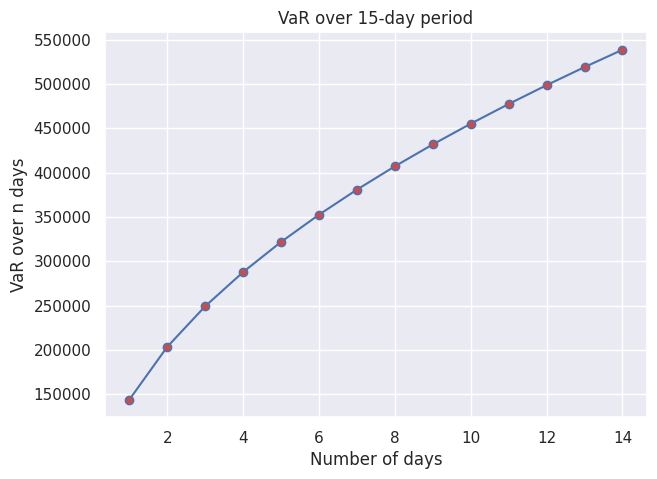

In [ ]:
VaR_n_days = []
n_days = range(1, 15)
for i in n_days:
    VaR_i_days = cut_off * np.sqrt(i)
    VaR_n_days.append(VaR_i_days)

plt.figure(figsize=(7, 5))
plt.plot(n_days, VaR_n_days, marker='o', markerfacecolor='r')
plt.xlabel('Number of days')
plt.ylabel('VaR over n days')
plt.title('VaR over 15-day period')
plt.show()